# GEOG 489 Project

## Introduction

### 1. Motivations

Food safety is a critical public health issue. In urban areas like Chicago, Illinois, government oversight of institutions that serve food to the public is important to maintain the health of the people who eat or acquire food at these institutions. Failure to follow proper health and safety codes on the part of private enterprises can lead to outbreaks of infectious and food-borne illnesses.

### 2. Goals

The City of Chicago plots every health inspection of a food-serving institution on a map along with the institution’s evaluated risk level (Low, Medium, High). By analyzing this data, we will be able to visualize which areas might be underserved and therefore at higher risk for poor food safety and increased risk of food-borne illnesses. We are interested to see if there is a correlation between risk level and demographic data, and will create visualizations to see how this changes. The available dataset has a decade of health inspection data, so we will be able to see if there are any long term trends, in regards to what kind of establishments are inspected more frequently, and what association there is with the demographics of the region. 


Additionally, we will plot these inspection records on the Chicago road network, which will allow us to perform route efficiency analysis to maximize the number of inspections a theoretical inspector could perform. We will perform a network analysis using the restaurants as nodes, to create a visualization of the nearest restaurants to a health inspection office. By optimizing the route a theoretical health inspector might take, we could improve the efficiency of health inspections and potentially service more restaurants on a daily basis. 


### 3. Datasets

- Shapefile of Chicago
- Food inspections: This dataset is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure.
- Census data: Selected socioeconomic indicators in Chicago
- Chicago road networks

![jupyter](./figures/road_networks.png)

## Implementation

### 0. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import time
import plotly.express as px
import seaborn
from dash import Dash, dcc, html, Input, Output
from collections import defaultdict
import warnings
import libpysal
import esda
warnings.filterwarnings('ignore')

### 1. Import Data

In [3]:
# Import shapefile
chicomm = gpd.read_file('./data/chicomm/chicomm.shp')
chicomm.head()

,CHICOMNO,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
0,0047,47,Burnside,30179,25946,9025,54900,371,"POLYGON ((-87.60020 41.73660, -87.59860 41.736..."
1,0054,54,Riverdale,7360,6401,3952,46000,115,"POLYGON ((-87.61220 41.68530, -87.61190 41.685..."
2,0001,1,Rogers Park,27330,23902,12603,108400,429,"POLYGON ((-87.67802 42.02298, -87.67771 42.023..."
3,0002,2,West Ridge,36791,31408,14792,127700,491,"POLYGON ((-87.70991 42.01177, -87.70920 42.011..."
4,0003,3,Uptown,22378,19711,12389,137800,378,"POLYGON ((-87.65520 41.97660, -87.65230 41.976..."


In [4]:
# Import food inspection data
inspections = pd.read_csv('./data/inspections_data_18_22.csv')
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2129828,CHICAGO PIZZA & OVEN GRINDER,CHICAGO PIZZA & OVEN GRINDER,28176.0,Restaurant,Risk 1 (High),2121 N CLARK ST,CHICAGO,IL,60614.0,1/2/2018,Complaint,No Entry,NaN,41.920808,-87.637425,"(-87.63742463183816, 41.92080847859943)"
1,2129833,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,76582.0,Restaurant,Risk 1 (High),2256 N ORCHARD ST,CHICAGO,IL,60614.0,1/2/2018,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.923518,-87.646418,"(-87.64641808703628, 41.92351840128967)"
2,2129829,FORK,FORK,1276082.0,Restaurant,Risk 1 (High),4600-4602 N LINCOLN AVE,CHICAGO,IL,60625.0,1/2/2018,Complaint,No Entry,NaN,41.964902,-87.686279,"(-87.68627917084095, 41.964902360748326)"
3,2129836,JIMMY JOHNS SANDWICH SHOPS,JIMMY JOHNS SANDWICH SHOPS,1695167.0,Restaurant,Risk 1 (High),2029 W DIVISION ST,CHICAGO,IL,60622.0,1/2/2018,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,41.903060,-87.678437,"(-87.67843725836676, 41.903059772046284)"
4,2129832,MORSE FRESH MARKET,MORSE FRESH MARKET,1518304.0,Grocery Store,Risk 1 (High),1430 W MORSE AVE,CHICAGO,IL,60626.0,1/2/2018,Canvass Re-Inspection,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,42.007995,-87.667174,"(-87.66717414671852, 42.00799491993327)"


In [5]:
# Import census data
census = pd.read_csv('./data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')
census.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


<AxesSubplot:>

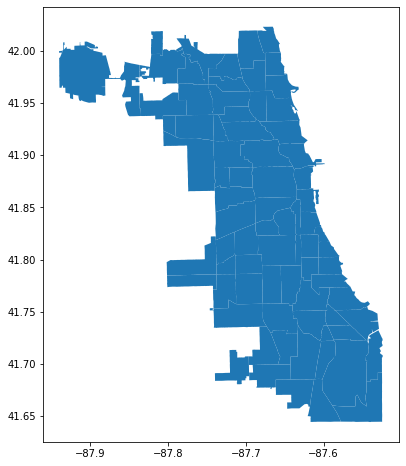

In [6]:
# Overview of the data
# Chicago shapefile
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
chicomm.plot(ax=ax)

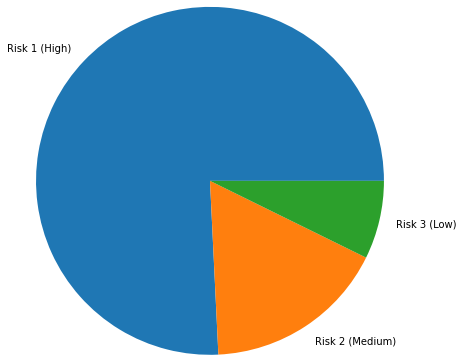

In [7]:
# Pie chart: risk level
inspections_by_risk = inspections.groupby('Risk').size()
plt.pie(inspections_by_risk,
        labels=inspections_by_risk.index.to_list(),
        radius=2);

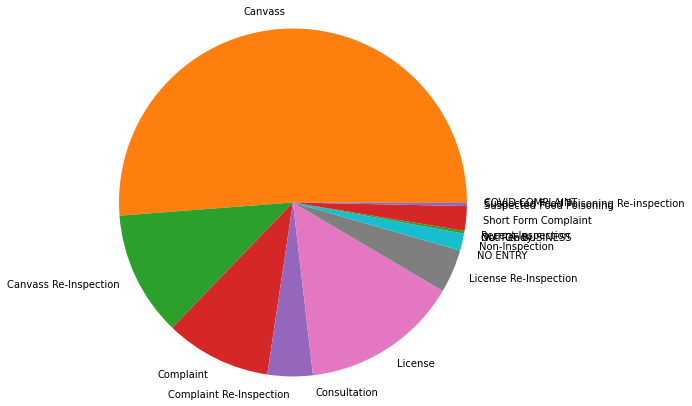

In [8]:
# Pie chart: inspection type
inspections_by_type = inspections.groupby('Inspection Type').size()
plt.pie(inspections_by_type,
        labels=inspections_by_type.index.to_list(),
        radius=2);

### 2. Data Preparation

In [9]:
# Prepare for merging
chicomm = chicomm[['DISTNAME', 'DISTITLE', 'geometry']]
chicomm.dtypes

DISTNAME       int64
DISTITLE      object
geometry    geometry
dtype: object

In [10]:
# Census data for each community
census_comm = census[:77]
census_chi = census[77:]

# Drop a useless column
census_comm = census_comm.drop(columns=['COMMUNITY AREA NAME'])

# Check data type
census_comm.dtypes

Community Area Number                           float64
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                                 int64
HARDSHIP INDEX                                  float64
dtype: object

In [11]:
# Convert data type for merging
census_comm['Community Area Number'] = census_comm['Community Area Number'].astype(int)

In [12]:
chicomm = chicomm.merge(census_comm, left_on='DISTNAME', right_on='Community Area Number')
chicomm.head()

,DISTNAME,DISTITLE,geometry,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,47,Burnside,"POLYGON ((-87.60020 41.73660, -87.59860 41.736...",47,6.8,33.0,18.6,19.3,42.7,12515,79.0
1,54,Riverdale,"POLYGON ((-87.61220 41.68530, -87.61190 41.685...",54,5.8,56.5,34.6,27.5,51.5,8201,98.0
2,1,Rogers Park,"POLYGON ((-87.67802 42.02298, -87.67771 42.023...",1,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,2,West Ridge,"POLYGON ((-87.70991 42.01177, -87.70920 42.011...",2,7.8,17.2,8.8,20.8,38.5,23040,46.0
4,3,Uptown,"POLYGON ((-87.65520 41.97660, -87.65230 41.976...",3,3.8,24.0,8.9,11.8,22.2,35787,20.0


In [13]:
# Reorganize inspection data
inspections = inspections.drop(columns=['Location'])

inspections['Inspection Date'] = inspections['Inspection Date'].map(lambda x: time.strptime(x, "%m/%d/%Y"))

In [14]:
inspections = gpd.GeoDataFrame(
    inspections, geometry=gpd.points_from_xy(inspections.Longitude, inspections.Latitude))

inspections = inspections.drop(columns=['Latitude', 'Longitude'])
inspections['Inspection Date']

0            (2018, 1, 2, 0, 0, 0, 1, 2, -1)
1            (2018, 1, 2, 0, 0, 0, 1, 2, -1)
2            (2018, 1, 2, 0, 0, 0, 1, 2, -1)
3            (2018, 1, 2, 0, 0, 0, 1, 2, -1)
4            (2018, 1, 2, 0, 0, 0, 1, 2, -1)
                        ...                 
67141    (2021, 12, 30, 0, 0, 0, 3, 364, -1)
67142    (2021, 12, 30, 0, 0, 0, 3, 364, -1)
67143    (2021, 12, 30, 0, 0, 0, 3, 364, -1)
67144    (2021, 12, 30, 0, 0, 0, 3, 364, -1)
67145    (2021, 12, 30, 0, 0, 0, 3, 364, -1)
Name: Inspection Date, Length: 67146, dtype: object

The module "time" in Python uses structures like above to record date and time. Attributes: tm_year, tm_mon, tm_mday, tm_hour, tm_min. tm_sec, tm_wday, tm_yday and tm_isdst. We only care about the date.

Now we need to organize the inspection data by inspection date. This step can be quite time consuming if we keep the geodataframe data structure. So we use list instead.

In [15]:
inspections = inspections.set_crs('epsg:4269')
inspections_by_year = defaultdict(list)

In [16]:
# For each row in the inspection dataset, we convert it to a list
for idx, row in inspections.iterrows():
    inspections_by_year[row['Inspection Date'][0]].append(row.tolist())

Convert 2-D lists to geodataframes.

In [17]:
for key in inspections_by_year:
    inspections_by_year[key] = gpd.GeoDataFrame(inspections_by_year[key], columns=inspections.columns)
    inspections_by_year[key] = inspections_by_year[key].set_crs('epsg:4269')
    
inspections_by_year[2020].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,geometry
0,2356072,ANNOYANCE PRODUCTIONS,THE ANNOYANCE THEATER,2262292.0,Restaurant,Risk 2 (Medium),851-853 W BELMONT AVE,CHICAGO,IL,60657.0,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",POINT (-87.65126 41.93984)
1,2356070,BE KIDS CAFE,BE KIDS CAFE,2589026.0,Restaurant,Risk 2 (Medium),2800 W NORTH AVE,CHICAGO,IL,60647.0,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",License,Pass,NaN,POINT (-87.69709 41.91033)
2,2356068,BE KIDS CAFE,BE KIDS CAFE,2589027.0,Restaurant,Risk 2 (Medium),2800 W NORTH AVE,CHICAGO,IL,60647.0,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",License Re-Inspection,Pass,NaN,POINT (-87.69709 41.91033)
3,2356080,BJ'S MARKET & BAKERY,BJ'S MARKET & BAKERY,2708808.0,Restaurant,Risk 1 (High),1737 E 95TH ST,CHICAGO,IL,60617.0,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",License,Not Ready,NaN,POINT (-87.58107 41.72229)
4,2356081,CHICAGO'S PIZZA,CHICAGO'S PIZZA,1696176.0,Restaurant,Risk 1 (High),4520 W IRVING PARK RD,CHICAGO,IL,60641.0,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",POINT (-87.74148 41.95360)


### 3. Dynamic Choropleth Maps

There are several ways to make choropleth maps in python. In our project, we will look into choropleth maps in two modules: geopandas and plotly.

#### 3.1 Choropleth maps in geopandas

In [19]:
# Spatial join
total_inspections = gpd.sjoin(inspections, chicomm[['DISTITLE', 'geometry']], op='within')
high_risk = gpd.sjoin(inspections[inspections['Risk']=='Risk 1 (High)'], chicomm[['DISTITLE', 'geometry']], op='within')

total_inspections_comm = total_inspections.groupby('DISTITLE').size()
high_risk_comm = high_risk.groupby('DISTITLE').size()

total_inspections_comm = total_inspections_comm.to_frame(name='Number of Total Inspections')
high_risk_comm = high_risk_comm.to_frame(name='Number of High Risk')

chicomm_sjoin = chicomm.merge(total_inspections_comm, left_on='DISTITLE', right_on='DISTITLE')
chicomm_sjoin = chicomm_sjoin.merge(high_risk_comm, left_on='DISTITLE', right_on='DISTITLE')

In [21]:
# High risk rate
chicomm_sjoin['Rate of High Risk'] = chicomm_sjoin.apply(lambda x: x['Number of High Risk']/x['Number of Total Inspections'], axis=1)

In [22]:
chicomm_sjoin.head()

,DISTNAME,DISTITLE,geometry,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Number of Total Inspections,Number of High Risk,Rate of High Risk
0,47,Burnside,"POLYGON ((-87.60020 41.73660, -87.59860 41.736...",47,6.8,33.0,18.6,19.3,42.7,12515,79.0,7,7,1.000000
1,54,Riverdale,"POLYGON ((-87.61220 41.68530, -87.61190 41.685...",54,5.8,56.5,34.6,27.5,51.5,8201,98.0,58,46,0.793103
2,1,Rogers Park,"POLYGON ((-87.67802 42.02298, -87.67771 42.023...",1,7.7,23.6,8.7,18.2,27.5,23939,39.0,1170,899,0.768376
3,2,West Ridge,"POLYGON ((-87.70991 42.01177, -87.70920 42.011...",2,7.8,17.2,8.8,20.8,38.5,23040,46.0,1631,1276,0.782342
4,3,Uptown,"POLYGON ((-87.65520 41.97660, -87.65230 41.976...",3,3.8,24.0,8.9,11.8,22.2,35787,20.0,1556,1231,0.791131


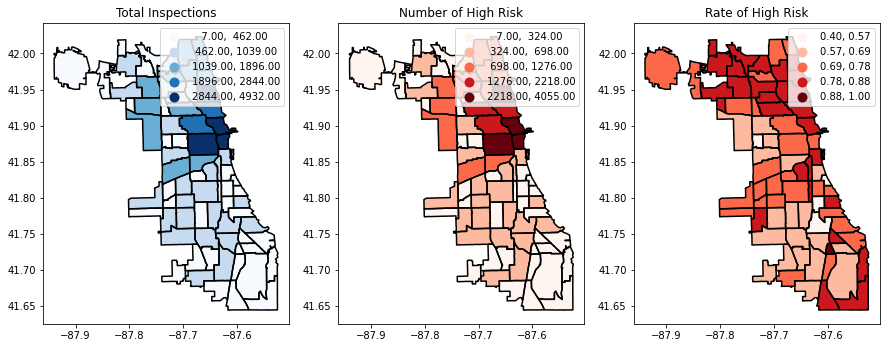

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].set_title('Total Inspections')
ax[1].set_title('Number of High Risk')
ax[2].set_title('Rate of High Risk')

chicomm.boundary.plot(ax=ax[0], color='black')
chicomm.boundary.plot(ax=ax[1], color='black')
chicomm.boundary.plot(ax=ax[2], color='black')

chicomm_sjoin.plot(column='Number of Total Inspections',
                   ax=ax[0],
                   cmap='Blues',
                   legend=True,
                   scheme='FisherJenks',
                   k=5)

chicomm_sjoin.plot(column='Number of High Risk',
                   ax=ax[1],
                   cmap='Reds',
                   legend=True,
                   scheme='FisherJenks',
                   k=5)

chicomm_sjoin.plot(column='Rate of High Risk',
                   ax=ax[2],
                   cmap='Reds',
                   legend=True,
                   scheme='FisherJenks',
                   k=5);

#### 3.2 Choropleth maps in plotly

First, let's take a look at an example of choropleth maps in plotly.express.

Overview: The plotly.express module (usually imported as px) contains functions that can create entire figures at once, and is referred to as Plotly Express or PX. Plotly Express is a built-in part of the plotly library, and is the recommended starting point for creating most common figures. More details: https://plotly.com/python/plotly-express/

We can use API plotly.express.choropleth to make choropleth maps:

In [ ]:
# chicomm_sjoin = chicomm_sjoin.set_index('DISTITLE')

fig = px.choropleth(chicomm_sjoin,
                    geojson=chicomm_sjoin.geometry,
                    locations=chicomm_sjoin.index,
                    color='Rate of High Risk',
                    color_continuous_scale="Reds",
                    projection="mercator")

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(
    title_text='Rate of High Risk'
)
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_layout(
    coloraxis_colorbar={'title':''})

fig.show()

In [ ]:
inspections_by_year.keys()

In [ ]:
# Organize data of 13 (4) years 
merged_data = gpd.GeoDataFrame()
for key in sorted(inspections_by_year):
    curr_data = inspections_by_year[key]
    total = gpd.sjoin(curr_data, chicomm[['DISTITLE', 'geometry']], op='within')
    high_risk = gpd.sjoin(curr_data[inspections['Risk']=='Risk 1 (High)'], chicomm[['DISTITLE', 'geometry']], op='within')

    total_comm = total.groupby('DISTITLE').size()
    high_risk_comm = high_risk.groupby('DISTITLE').size()

    total_comm = total_comm.to_frame(name='Number of Total Inspections')
    high_risk_comm = high_risk_comm.to_frame(name='Number of High Risk')

    curr_data_sjoin = chicomm.merge(total_comm, left_on='DISTITLE', right_on='DISTITLE')
    curr_data_sjoin = curr_data_sjoin.merge(high_risk_comm, left_on='DISTITLE', right_on='DISTITLE')

    curr_data_sjoin['Rate of High Risk'] = curr_data_sjoin.apply(lambda x: x['Number of High Risk']/x['Number of Total Inspections'], axis=1)
    curr_data_sjoin['Year'] = key
    merged_data = merged_data.append(curr_data_sjoin)

In [ ]:
merged_data.head()

In [ ]:
# Dynamic map with timeline
# merged_data = merged_data.set_index('DISTITLE')
fig = px.choropleth(merged_data,
                    geojson=merged_data.geometry,
                    locations=merged_data.index,
                    color='Rate of High Risk',
                    color_continuous_scale="Reds",
                    animation_frame='Year',
                    projection="mercator")

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(
    title_text='Rate of High Risk'
)
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_layout(
    coloraxis_colorbar={'title':''})

fig.show()

### 4. Correlation Analysis

In [ ]:
seaborn.pairplot(chicomm_sjoin,
                 x_vars=['PERCENT OF HOUSING CROWDED',
                         'PERCENT HOUSEHOLDS BELOW POVERTY',
                         'PER CAPITA INCOME ',
                         'PERCENT AGED 16+ UNEMPLOYED',
                         'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA'],
                 y_vars='Rate of High Risk',
                 kind='reg',
                 height=5
                );

### 5. Spatial Autocorrelation

In [ ]:
w_queen = libpysal.weights.Queen.from_dataframe(chicomm_sjoin[['Rate of High Risk', 'geometry']])
w_rook = libpysal.weights.Rook.from_dataframe(chicomm_sjoin[['Rate of High Risk', 'geometry']])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

chicomm_sjoin.boundary.plot(ax=axes[0], ls=':', color='black')
w_rook.plot(chicomm_sjoin, ax=axes[0], 
            edge_kws=dict(color='r', linestyle=':', linewidth=1),
            node_kws=dict(marker=''))

chicomm_sjoin.boundary.plot(ax=axes[1], ls=':', color='black')
w_queen.plot(chicomm_sjoin, ax=axes[1], 
             edge_kws=dict(color='r', linestyle=':', linewidth=1),
             node_kws=dict(marker=''))

In [ ]:
y = chicomm_sjoin['Rate of High Risk']

mi_rook = esda.moran.Moran(y, w_rook)
mi_queen = esda.moran.Moran(y, w_queen)
print(f"Moran's I with Rook's case contiguity: {round(mi_rook.I, 3)}, p-value: {round(mi_rook.p_norm, 3)}")
print(f"Moran's I with Queen's case contiguity: {round(mi_queen.I, 3)}, p-value: {round(mi_queen.p_norm, 3)}")

### 6. Demographic Analysis

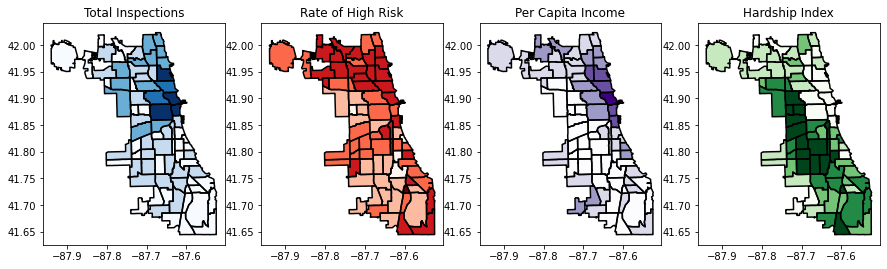

In [24]:
# Plot relevant inspection and demographic data 
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax[0].set_title('Total Inspections')
ax[1].set_title('Rate of High Risk')
ax[2].set_title('Per Capita Income')
ax[3].set_title('Hardship Index')

chicomm.boundary.plot(ax=ax[0], color='black')
chicomm.boundary.plot(ax=ax[1], color='black')
chicomm.boundary.plot(ax=ax[2], color='black')
chicomm.boundary.plot(ax=ax[3], color='black')

chicomm_sjoin.plot(column='Number of Total Inspections',
                   ax=ax[0],
                   cmap='Blues',
                   legend=False,
                   scheme='FisherJenks',
                   k=5)

chicomm_sjoin.plot(column='Rate of High Risk',
                   ax=ax[1],
                   cmap='Reds',
                   legend=False,
                   scheme='FisherJenks',
                   k=5);
chicomm_sjoin.plot(column='PER CAPITA INCOME ',
                   ax=ax[2],
                   cmap='Purples',
                   legend=False,
                   scheme='FisherJenks',
                   k=5);
chicomm_sjoin.plot(column='HARDSHIP INDEX',
                   ax=ax[3],
                   cmap='Greens',
                   legend=False,
                   scheme='FisherJenks',
                   k=5);

In [25]:
#Calculate Correlation Coefficient Matrix with relevant columns
demographics = chicomm_sjoin.copy()
for col in demographics.columns:
    if col != 'PER CAPITA INCOME ' and col != 'HARDSHIP INDEX' and col != 'Number of Total Inspections' and col != 'Rate of High Risk':
        demographics = demographics.drop([col], axis=1)
        
demo_corr_pearson = demographics.corr(method='pearson')

# Positive correlation between Per Capita Income and Number of Total Inspections
# Negative correlation between Hardship index and Number of Total Inspections.

In [26]:
demo_corr_pearson

,PER CAPITA INCOME,HARDSHIP INDEX,Number of Total Inspections,Rate of High Risk
PER CAPITA INCOME,1.000000,-0.849167,0.682373,0.374203
HARDSHIP INDEX,-0.849167,1.000000,-0.443497,-0.443749
Number of Total Inspections,0.682373,-0.443497,1.000000,0.187794
Rate of High Risk,0.374203,-0.443749,0.187794,1.000000


# Network and Spatial Analysis
#### Author: Nathan Seiler

## 0. Import Necessary Packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import datetime
import random

import osmnx as ox
import networkx as nx

import pulp
from pulp import *

from scipy.spatial.distance import cdist
import libpysal as ps
import matplotlib.pyplot as plt

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, MultiLineString, Polygon

## 1. Import Data

In [2]:
# health inspection data
inspections = pd.read_csv('./data/inspections_data_18_22.csv')
# Chicago communities shapefile with population data included
chi_comm_pop = gpd.read_file('./data/chicago_comm_pop/chicago_comm_pop.shp')
# Chicago communities with geometry
chi_comm_geo = gpd.read_file('./data/chicomm/chicomm.shp')

## 2. Clean and Merge Datasets

We aren't going to use the location column because it is formatted incorrectly, so let's get rid of it. 

In [3]:
inspections = inspections.drop(columns=['Location'])

We are going to spatially reference the geometry and add the coordinate reference system. 

In [4]:
inspections = gpd.GeoDataFrame(
    inspections, geometry=gpd.points_from_xy(inspections.Latitude, inspections.Longitude))

inspections = inspections.drop(columns=['Latitude', 'Longitude'])
inspections = inspections.set_crs('epsg:4269')

In [5]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,geometry
0,2129828,CHICAGO PIZZA & OVEN GRINDER,CHICAGO PIZZA & OVEN GRINDER,28176.0,Restaurant,Risk 1 (High),2121 N CLARK ST,CHICAGO,IL,60614.0,1/2/2018,Complaint,No Entry,NaN,POINT (41.92081 -87.63742)
1,2129833,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,76582.0,Restaurant,Risk 1 (High),2256 N ORCHARD ST,CHICAGO,IL,60614.0,1/2/2018,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,POINT (41.92352 -87.64642)
2,2129829,FORK,FORK,1276082.0,Restaurant,Risk 1 (High),4600-4602 N LINCOLN AVE,CHICAGO,IL,60625.0,1/2/2018,Complaint,No Entry,NaN,POINT (41.96490 -87.68628)
3,2129836,JIMMY JOHNS SANDWICH SHOPS,JIMMY JOHNS SANDWICH SHOPS,1695167.0,Restaurant,Risk 1 (High),2029 W DIVISION ST,CHICAGO,IL,60622.0,1/2/2018,Canvass,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,POINT (41.90306 -87.67844)
4,2129832,MORSE FRESH MARKET,MORSE FRESH MARKET,1518304.0,Grocery Store,Risk 1 (High),1430 W MORSE AVE,CHICAGO,IL,60626.0,1/2/2018,Canvass Re-Inspection,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,POINT (42.00799 -87.66717)


#### Remove Unnecessary Columns

In [6]:
inspections_clean = inspections.drop(columns=['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'City', 'State', 'Zip', 'Results', 'Violations'])

In [7]:
inspections_clean.head()

,Risk,Address,Inspection Date,Inspection Type,geometry
0,Risk 1 (High),2121 N CLARK ST,1/2/2018,Complaint,POINT (41.92081 -87.63742)
1,Risk 1 (High),2256 N ORCHARD ST,1/2/2018,Canvass,POINT (41.92352 -87.64642)
2,Risk 1 (High),4600-4602 N LINCOLN AVE,1/2/2018,Complaint,POINT (41.96490 -87.68628)
3,Risk 1 (High),2029 W DIVISION ST,1/2/2018,Canvass,POINT (41.90306 -87.67844)
4,Risk 1 (High),1430 W MORSE AVE,1/2/2018,Canvass Re-Inspection,POINT (42.00799 -87.66717)


#### Reformatting the 'Inspection Date' Column

In [8]:
type(inspections_clean['Inspection Date'][0])

str

In [9]:
inspections_clean['year'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).year
inspections_clean['month'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).month
inspections_clean['day'] = pd.DatetimeIndex(inspections_clean['Inspection Date']).day
inspections_clean.head()

,Risk,Address,Inspection Date,Inspection Type,geometry,year,month,day
0,Risk 1 (High),2121 N CLARK ST,1/2/2018,Complaint,POINT (41.92081 -87.63742),2018,1,2
1,Risk 1 (High),2256 N ORCHARD ST,1/2/2018,Canvass,POINT (41.92352 -87.64642),2018,1,2
2,Risk 1 (High),4600-4602 N LINCOLN AVE,1/2/2018,Complaint,POINT (41.96490 -87.68628),2018,1,2
3,Risk 1 (High),2029 W DIVISION ST,1/2/2018,Canvass,POINT (41.90306 -87.67844),2018,1,2
4,Risk 1 (High),1430 W MORSE AVE,1/2/2018,Canvass Re-Inspection,POINT (42.00799 -87.66717),2018,1,2


In [10]:
type(inspections_clean['year'][0])

numpy.int64

In [11]:
inspections_clean = inspections_clean.drop(columns = ['Inspection Date'])
inspections_clean.head()

,Risk,Address,Inspection Type,geometry,year,month,day
0,Risk 1 (High),2121 N CLARK ST,Complaint,POINT (41.92081 -87.63742),2018,1,2
1,Risk 1 (High),2256 N ORCHARD ST,Canvass,POINT (41.92352 -87.64642),2018,1,2
2,Risk 1 (High),4600-4602 N LINCOLN AVE,Complaint,POINT (41.96490 -87.68628),2018,1,2
3,Risk 1 (High),2029 W DIVISION ST,Canvass,POINT (41.90306 -87.67844),2018,1,2
4,Risk 1 (High),1430 W MORSE AVE,Canvass Re-Inspection,POINT (42.00799 -87.66717),2018,1,2


## 3. Create a sample network graph

#### Grab and store coordinates of Chicago Department of Public Health

In [12]:
cdph_lexingtonSt_coord = (41.87542275191835, -87.68051207654261)

*Source: Google Maps*

#### The Lexington Street location is the only one listed on their [site](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants.html) for health inspections, so let's assume that all health inspectors leave from this one location.

In [13]:
near_west_side = ox.graph_from_place('Near West Side, Chicago, Illinois', network_type = 'drive', simplify = True)

In [14]:
origin_node = ox.get_nearest_node(near_west_side, cdph_lexingtonSt_coord)
#picking a random coordinate of an inspection in the Near West Side
destination_node = ox.get_nearest_node(near_west_side, (42.01219,-87.67472))

/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [15]:
a_star_route = nx.astar_path(near_west_side, origin_node, destination_node, weight="length")

In [16]:
near_west_side = ox.add_edge_speeds(near_west_side)

# calculate travel time (seconds) for all edges
near_west_side = ox.add_edge_travel_times(near_west_side)

edges = ox.graph_to_gdfs(near_west_side, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
motorway,328.9,82.1,14.2
motorway_link,290.2,88.5,11.8
primary,98.4,66.8,5.3
primary_link,62.5,66.8,3.4
residential,112.0,66.8,6.0
road,28.2,66.8,1.5
secondary,118.7,48.3,8.9
secondary_link,49.4,66.8,2.7
tertiary,107.5,48.3,8.0


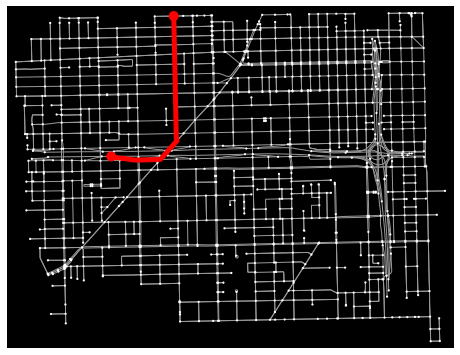

In [17]:
fig, ax = ox.plot_graph_route(near_west_side, a_star_route, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

In [18]:
dijstra_route_time=nx.dijkstra_path(near_west_side, origin_node, destination_node, weight="travel_time")

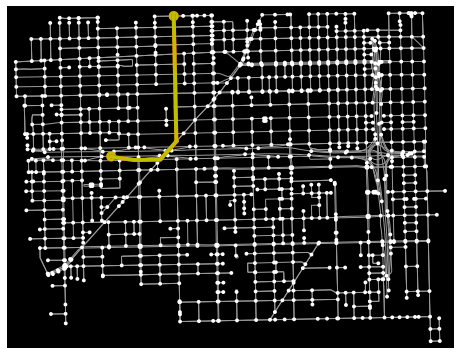

In [19]:
fig, ax = ox.plot_graph_routes(near_west_side, routes=[a_star_route,dijstra_route_time], route_colors=['r', 'y'], bgcolor='k', route_alpha=1)

In [20]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [2*60, 3*60, 5*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

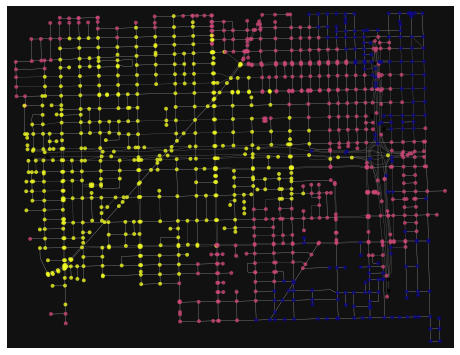

In [21]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(near_west_side, origin_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in near_west_side.nodes()]
fig, ax = ox.plot_graph(near_west_side, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

### Let's try a larger network

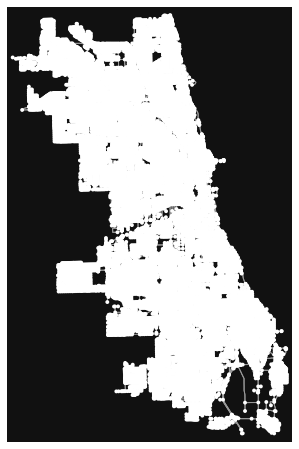

CPU times: user 51.8 s, sys: 233 ms, total: 52 s
Wall time: 52 s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [24]:
%%time

chicago = ox.graph_from_place('Chicago, Illinois', network_type='drive', simplify=True)
ox.plot_graph(chicago)

In [52]:
chicago = ox.add_edge_speeds(chicago)

# calculate travel time (seconds) for all edges
chicago = ox.add_edge_travel_times(chicago)

edges = ox.graph_to_gdfs(chicago, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",250.3,32.2,28.0
"['motorway_link', 'secondary']",401.3,83.1,17.4
"['motorway_link', 'tertiary']",246.2,83.1,10.7
"['primary', 'motorway_link']",254.9,49.2,18.6
"['primary', 'secondary']",262.0,49.2,19.2
"['residential', 'tertiary']",225.5,39.2,20.7
"['secondary', 'tertiary']",144.3,49.0,10.6
"['secondary', 'trunk']",172.2,49.0,12.7
"['secondary_link', 'motorway_link']",174.7,32.2,19.5


In [55]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch


trip_times = [5*60, 15*60, 30*60] #in seconds

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

isochrone_polys = []


for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(chicago, origin_node, radius=trip_time, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

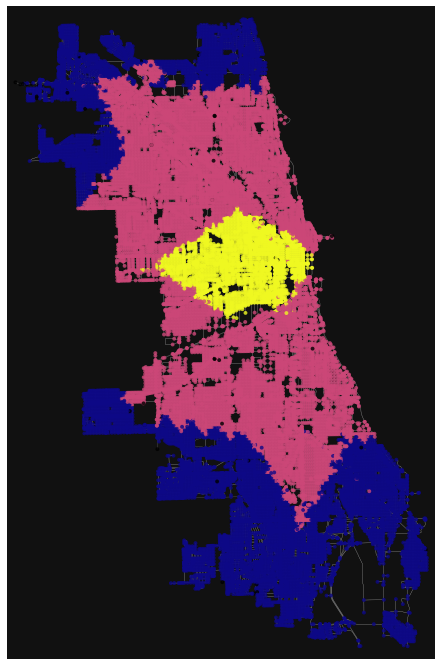

In [57]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(chicago, origin_node, radius=trip_time, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in chicago.nodes()]
fig, ax = ox.plot_graph(chicago, node_color=nc, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999',figsize = (12,12))

## 4. Spatial Optimization using the P-median Problem

Let's say we would like to place a number *P* of facilities while minimizing the total weighted distance of servicing all demands. Each node has an associated weight that represents the amount of demand at that nodes, we will use population because a health department is an important community resource. 

**Objective function:** Minimizing demand-weighted summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location 

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not. 

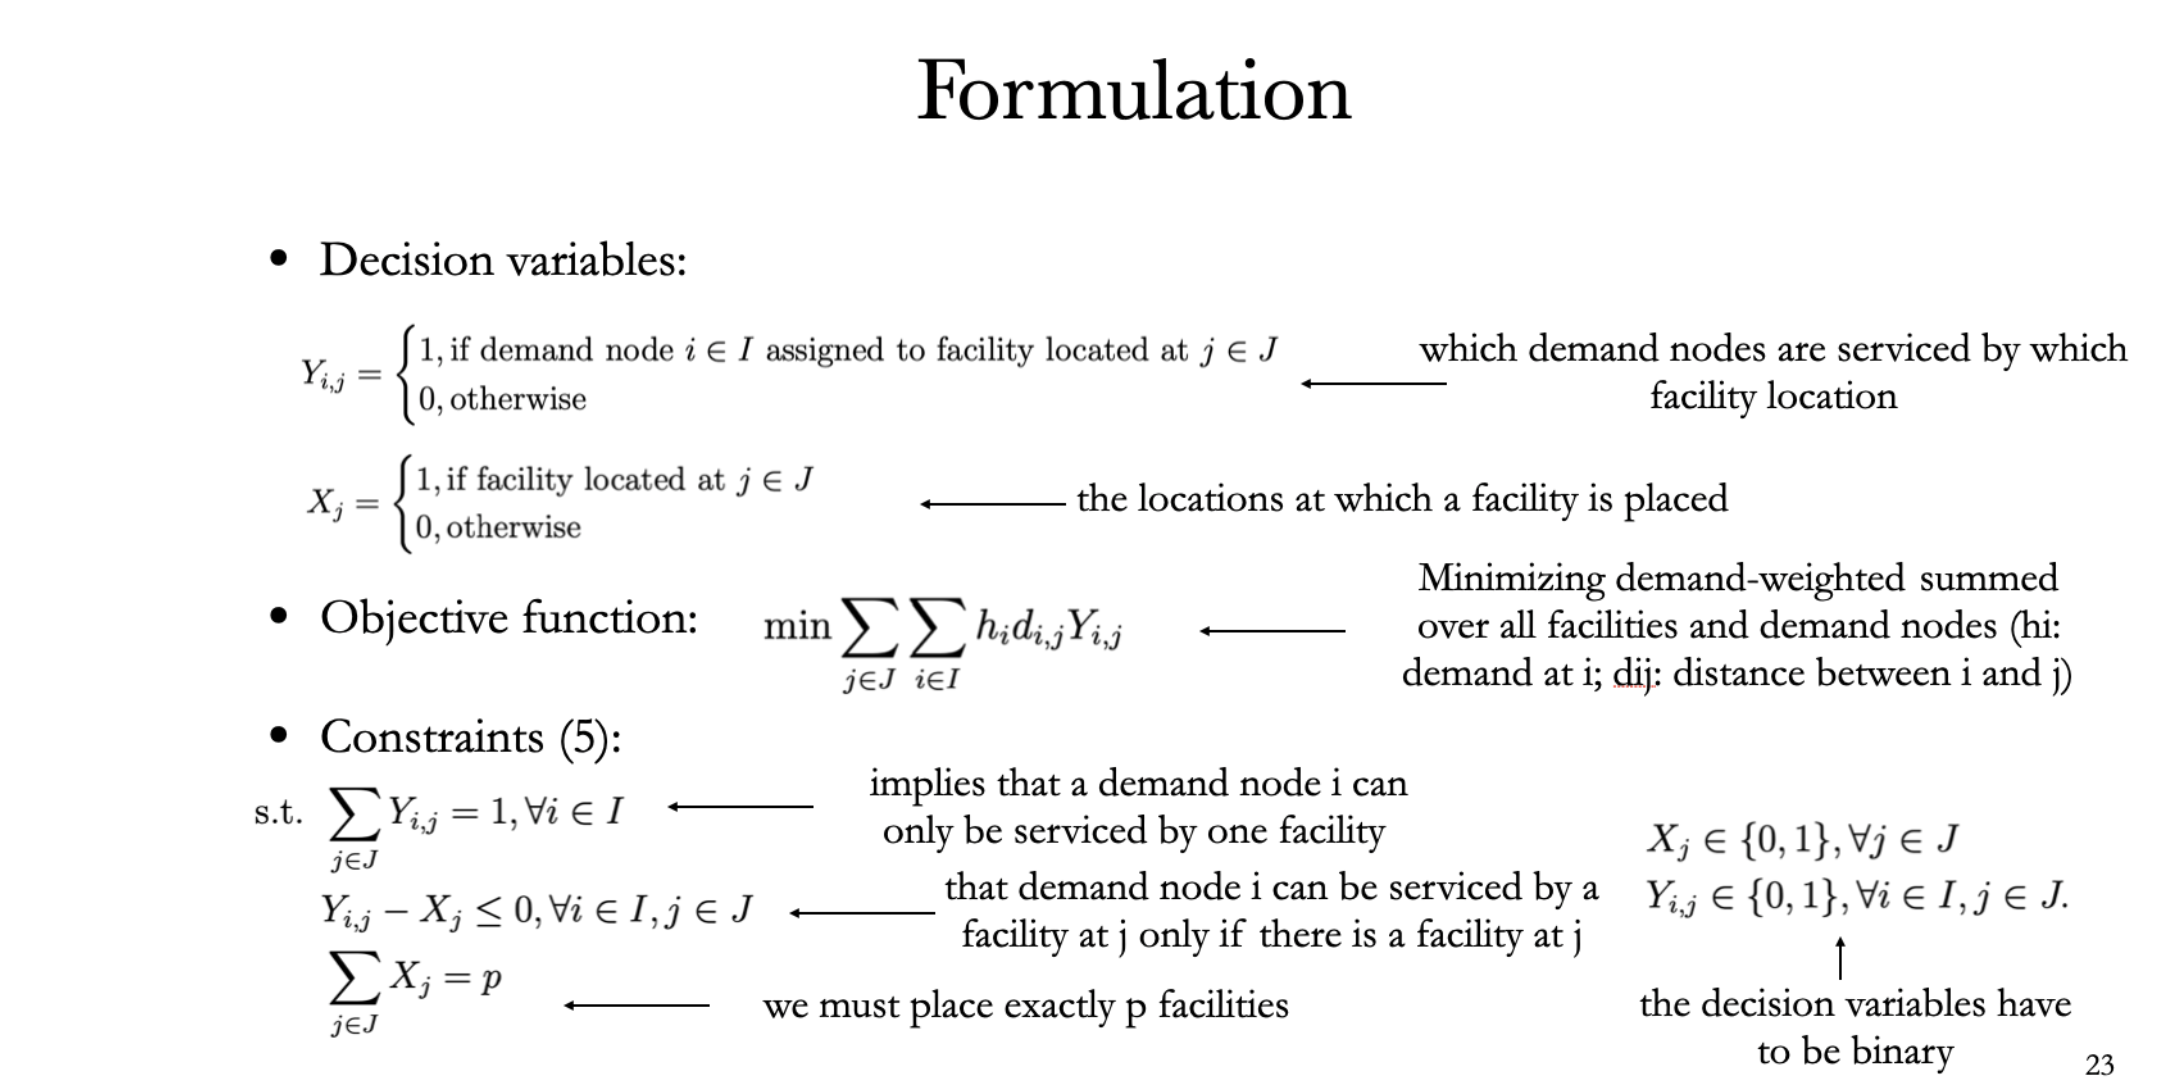

In [58]:
il = gpd.read_file('./data/chicago_comm_pop/chicago_comm_pop.shp')

In [59]:
il.head()

,GeoKey,Total_Pop,geometry
0,35,18238,"POLYGON ((-9752604.951 5137743.450, -9752605.8..."
1,36,5918,"POLYGON ((-9750713.852 5133595.674, -9750731.1..."
2,37,2876,"POLYGON ((-9754793.199 5131350.020, -9754792.7..."
3,38,21929,"POLYGON ((-9752334.139 5133578.410, -9752333.7..."
4,39,17841,"POLYGON ((-9750713.852 5133595.674, -9750713.4..."


In [60]:
#create demand and potential facility nodes
demand = np.arange(0,77,1)
facilities = np.arange(0,77,1)

In [61]:
#create a distance matrix
coords = list(zip(il.centroid.x,il.centroid.y))
d = cdist(coords,coords) 

In [62]:
#here we use demand as the total population
h = il.Total_Pop.values

In [63]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary')

let's assume that we want to have 5 departments - change *p* if you want to build more or less

In [66]:
p = 5

prob = LpProblem('P_Median', LpMinimize)

Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 

h_i: demand at *i*; *d_ij*: distance between *i* and *j*

In [74]:
prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [75]:
prob += sum([X[j] for j in facilities]) == p

This constraint implies that a demand node *i* can only be serviced by one facility

In [76]:
for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1

This constraint implies that that demand node *i* can be serviced by a facility at *j* only if there is a facility at *j*. It implicitly removes situation when node *i* is served by *j* but there is no facility at *j*. 

In [77]:
for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [78]:
%%time

prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 258 ms, sys: 67.5 ms, total: 325 ms
Wall time: 708 ms


In [79]:
print("Objective: ",value(prob.objective))

Objective:  14217783986.21611


In [80]:
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  18
Facility Node:  24
Facility Node:  39
Facility Node:  5
Facility Node:  60


In [81]:
fac_loc = il.iloc[rslt,:]

<AxesSubplot:>

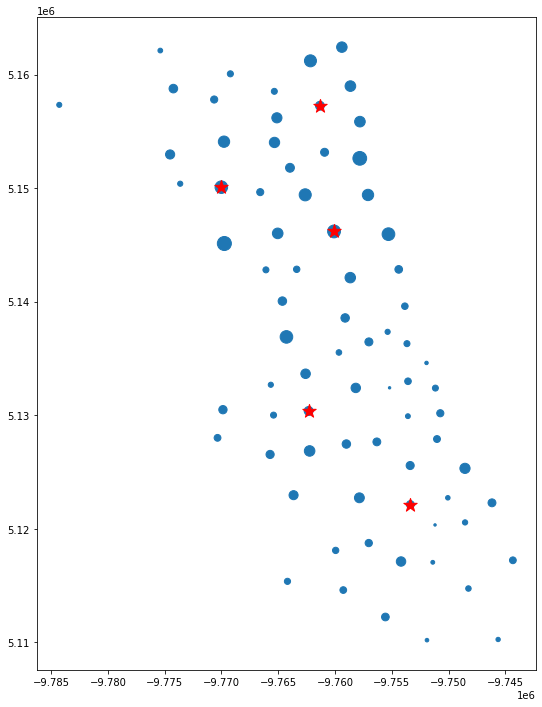

In [87]:
fig, ax = plt.subplots(figsize=(12,12))

il.centroid.plot(ax=ax,markersize=il.Total_Pop/500) # marker size is proportional to the population
fac_loc.centroid.plot(ax=ax,color="red",markersize=200,marker="*")

In [83]:
from shapely.geometry import LineString, MultiLineString
lines = []
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        left, right = (int(subV[1]), int(subV[2]))
        line = LineString([il.iloc[left,:].geometry.centroid, il.iloc[right,:].geometry.centroid])
        lines.append(line)
gdf_lines = gpd.GeoDataFrame(geometry=lines)

(-9791764.037241032, -9740827.057254149, 5105054.073132936, 5167258.616755508)

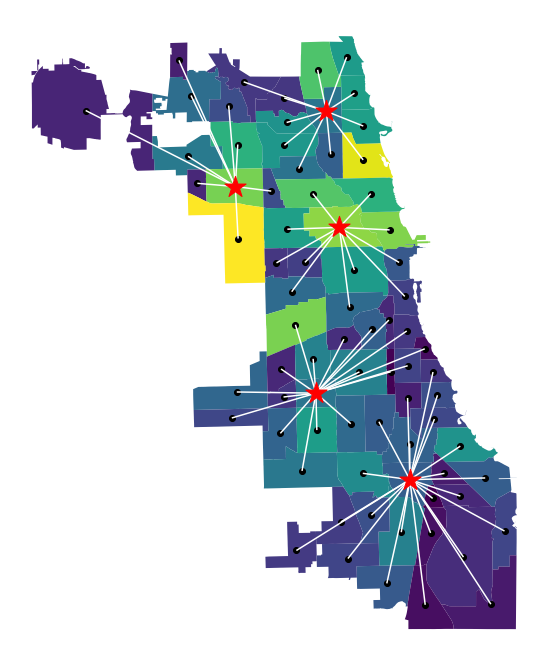

In [84]:
fig, ax = plt.subplots(figsize=(12,12))

il.plot(ax=ax,column="Total_Pop") # markersize is proportional to the population
il.centroid.plot(ax=ax,color="black")
gdf_lines.plot(ax=ax,color="white")
fac_loc.centroid.plot(ax=ax,color="red",markersize=500,marker="*",zorder=2)
plt.axis('off')